In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


In [2]:
N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 10**2


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(x)
%run Data_Generator.ipynb

<Figure size 640x480 with 1 Axes>

In [3]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

# Reconfiguration Full

In [4]:
#----------------------------#
# Define T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out

In [28]:
class Reconfiguration_unit_steps(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.scale = self.add_weight(name='scale',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        # Step 3
        self.scale_b = self.add_weight(name='scale_b',
                            shape=input_shape[1:],
                            initializer='GlorotUniform',
                            trainable=True)
        
        ## Steps 4-9
        self.tangentbiases = self.add_weight(name='tangentbiases',
                                    shape=input_shape[1:],
                                    initializer='GlorotNormal',
                                    trainable=True)
        self.tangentweights = self.add_weight(name='tangentweights',
                                    shape=input_shape[1:],
                                    initializer='GlorotNormal',
                                    trainable=True)
        self.location_b = self.add_weight(name='location_b',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
 

    def call(self, input):
        ### Steps 1-2
        # Relocated
        input_relocated = input + self.location
        # Rescaled
        output_steps_1_2 = tf.math.multiply(self.scale,input_relocated)
        
        ### Step 3
        x_in_abs = tf.math.abs(output_steps_1_2) < 10**-2#np.abs(np.random.normal(1,1,1))
        output_steps_1_2 = tf.math.multiply(self.scale_b,output_steps_1_2)
        output_step_3 = tf.where(x_in_abs,bump_True(output_steps_1_2),bump_False(output_steps_1_2))
        
        ### Step 4-9
        x_out = tf.math.multiply(tf.math.abs(self.tangentweights),output_step_3) + self.tangentbiases
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.diag(x_out)
        #x_out = tf.linalg.expm(x_out)
        x_out = x_out + tf.linalg.matmul(x_out,x_out)/2 + tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))/6 +tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out)))/24 #+tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))))/120
        
        # TEMP: # If things are crashing use this
        #x_out = tf.math.exp(x_out)
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,input)
        
        # 9. Recenter Transformed Data
        output_steps_4_9 = x_out + self.location_b
        
        # Return Output
        return output_steps_4_9

In [29]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

In [30]:
# Initialize
input_layer = tf.keras.Input(shape=[d+D])
# Steps 1 and 2
reconfigure  = Reconfiguration_unit_steps()
current_layer = reconfigure(input_layer)
# Apply Reconfigurations
# for i in range(N_Reconfigurations):
#     reconfigure  = Reconfiguration_unit_steps()
#     current_layer = reconfigure(current_layer)
# Map back to R^D
output_layer = projection_layer(current_layer)
NEU_OLS = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
# Summarize Model
NEU_OLS.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_4 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_4 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_4 (None, 2)                 12  

In [31]:
optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)


NEU_OLS.compile(loss='mse',
                optimizer=optimizer_on,
                metrics=['mse'])

In [32]:
history = NEU_OLS.fit(
          data_NEU, NEU_targets,
          epochs=Epochs)

Train on 100 samples
Epoch 1/100
100/100 [==============================] - 6s 64ms/sample - loss: 0.9828 - mse: 0.9828
Epoch 2/100
100/100 [==============================] - 0s 259us/sample - loss: 1.1577 - mse: 1.1577
Epoch 3/100
100/100 [==============================] - 0s 358us/sample - loss: 0.6541 - mse: 0.6541
Epoch 4/100
100/100 [==============================] - 0s 318us/sample - loss: 0.6118 - mse: 0.6118
Epoch 5/100
100/100 [==============================] - 0s 399us/sample - loss: 0.5864 - mse: 0.5864
Epoch 6/100
100/100 [==============================] - 0s 279us/sample - loss: 0.5710 - mse: 0.5710
Epoch 7/100
100/100 [==============================] - 0s 304us/sample - loss: 0.5670 - mse: 0.5670
Epoch 8/100
100/100 [==============================] - 0s 330us/sample - loss: 0.5577 - mse: 0.5577
Epoch 9/100
100/100 [==============================] - 0s 308us/sample - loss: 0.5532 - mse: 0.5532
Epoch 10/100
100/100 [==============================] - 0s 391us/sample - loss: 

100/100 [==============================] - 0s 277us/sample - loss: 0.5351 - mse: 0.5351
Epoch 83/100
100/100 [==============================] - 0s 263us/sample - loss: 0.5342 - mse: 0.5342
Epoch 84/100
100/100 [==============================] - 0s 311us/sample - loss: 0.5344 - mse: 0.5344
Epoch 85/100
100/100 [==============================] - 0s 267us/sample - loss: 0.5352 - mse: 0.5352
Epoch 86/100
100/100 [==============================] - 0s 328us/sample - loss: 0.5353 - mse: 0.5353
Epoch 87/100
100/100 [==============================] - 0s 284us/sample - loss: 0.5350 - mse: 0.5350
Epoch 88/100
100/100 [==============================] - 0s 299us/sample - loss: 0.5342 - mse: 0.5342
Epoch 89/100
100/100 [==============================] - 0s 287us/sample - loss: 0.5350 - mse: 0.5350
Epoch 90/100
100/100 [==============================] - 0s 275us/sample - loss: 0.5341 - mse: 0.5341
Epoch 91/100
100/100 [==============================] - 0s 291us/sample - loss: 0.5343 - mse: 0.5343
Epo

In [33]:
# Projection
NEU_prediction = NEU_OLS.predict(data_NEU)
np.shape(NEU_prediction)

(100, 1)

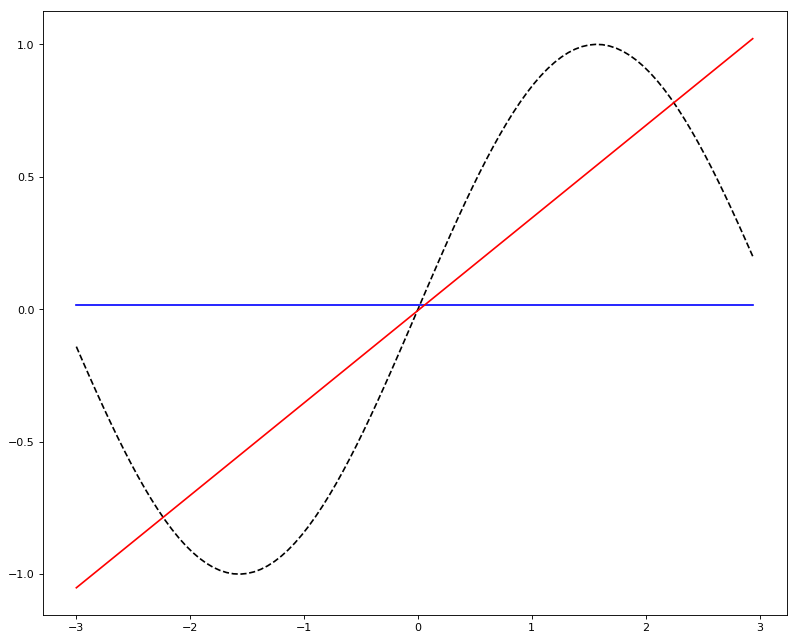

In [34]:
# import matplotlib.pyplot as plt
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Plot Models
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')
plt.plot(data_x,NEU_prediction,color='b',label='NEU-OLS')
plt.plot(data_x,model_pred_y,color='r',label='NEU-OLS')